# TANZANIA WATER PUMP ANALYSIS

# Introduction

A good understanding of which water pumps will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania. This proposal contains an analysis of Tanzanian water pump data in order to provide the Tanzania Government a tool with which to determine water pump functionality and information on how to improve pump maintenance efficiency. This analysis will focus to determining which factors needs attention to increase efficiency of the water pumps. The Tanzanian Government can use this analysis to improve prediction and identification of which pumps are non functional or may need repair, therefore increasing access to potable water across Tanzania.

# Business Problem

The Tanzania Government is trying to improve their water pump maintenance operations in order to ensure that clean, potable water is available to communities across Tanzania. In order to accomplish this, the Government wants to be able to better predict which pumps will fail, and to better identify pumps that need repair and what factors need to be considered in the future. This will help in improving maintenance efficiency and water access. 

# Data Understanding

The data used in this analysis is provided by Tanzania's Government and compiled by Taarifa available at DrivenData.The data set contains 41 variables describing pump functionality status (the target variable), pump geographic location, what kind of pump is operating, when it was installed, how it is managed, etc. It includes data on 59,400 individual pumps recorded from 2011-2013.

In [96]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,ExtraTreesClassifier, VotingClassifier, StackingRegressor

import warnings
warnings.filterwarnings('ignore')
#!pip install missingno
import missingno as missingno
import matplotlib.image as mpimg
#!pip install yellowbrick
from yellowbrick.classifier import ROCAUC


In [2]:
#setting a format in which the data will be displayed
pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [3]:
#loading data
training_values_df= pd.read_csv('training-set-values.csv')
training_values_df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.00000000,3/14/2011,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.00000000,3/6/2013,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.00000000,2/25/2013,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.00000000,1/28/2013,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.00000000,7/13/2011,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.00000000,5/3/2013,Germany Republi,1210,CES,37.16980689,-3.25384746,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.00000000,5/7/2011,Cefa-njombe,1212,Cefa,35.24999126,-9.07062880,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.00000000,4/11/2011,NaN,0,NaN,34.01708706,-8.75043433,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.00000000,3/8/2011,Malec,0,Musa,35.86131531,-6.37857327,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [69]:
#Loading target data

training_labels_df = pd.read_csv('training-set-labels.csv')
training_labels_df

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [5]:
#Combine dataframes to create complete dataframe

raw_training_df = pd.merge(training_labels_df, training_values_df)
raw_training_df

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.00000000,3/14/2011,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.00000000,3/6/2013,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.00000000,2/25/2013,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.00000000,1/28/2013,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.00000000,7/13/2011,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.00000000,5/3/2013,Germany Republi,1210,CES,37.16980689,-3.25384746,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,functional,4700.00000000,5/7/2011,Cefa-njombe,1212,Cefa,35.24999126,-9.07062880,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,functional,0.00000000,4/11/2011,NaN,0,NaN,34.01708706,-8.75043433,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,functional,0.00000000,3/8/2011,Malec,0,Musa,35.86131531,-6.37857327,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [6]:
#Create copy of raw data frame to iterate on

training_df = raw_training_df.copy()
training_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.00000000,3/14/2011,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.00000000,3/6/2013,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.00000000,2/25/2013,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.00000000,1/28/2013,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.00000000,7/13/2011,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
#Dispay data frame info

training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

From the above information we can see that we have some missing data in some datasets such as scheme_name

In [8]:
training_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000
mean,37115.13176768,317.65038468,668.29723906,34.07742669,-5.70603266,0.47414141,15.29700337,5.62974747,179.90998316,1300.65247475
std,21453.12837132,2997.57455814,693.11635032,6.56743185,2.94601908,12.23622981,17.58740634,9.63364863,471.48217574,951.62054732
min,0.00000000,0.00000000,-90.00000000,0.00000000,-11.64944018,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000
25%,18519.75000000,0.00000000,0.00000000,33.09034738,-8.54062131,0.00000000,5.00000000,2.00000000,0.00000000,0.00000000
50%,37061.50000000,0.00000000,369.00000000,34.90874343,-5.02159665,0.00000000,12.00000000,3.00000000,25.00000000,1986.00000000
75%,55656.50000000,20.00000000,1319.25000000,37.17838657,-3.32615564,0.00000000,17.00000000,5.00000000,215.00000000,2004.00000000
max,74247.00000000,350000.00000000,2770.00000000,40.34519307,-0.00000002,1776.00000000,99.00000000,80.00000000,30500.00000000,2013.00000000


From the above data description we can see that some of the datasets have 0 as the minimum this means that some of the data 
have been filled by zero hence needs to be addressed.

# DATA PREPARATION

In [9]:
#Check data for duplicates

duplicates = training_df.duplicated(keep = False)
duplicates.value_counts()

False    59400
dtype: int64

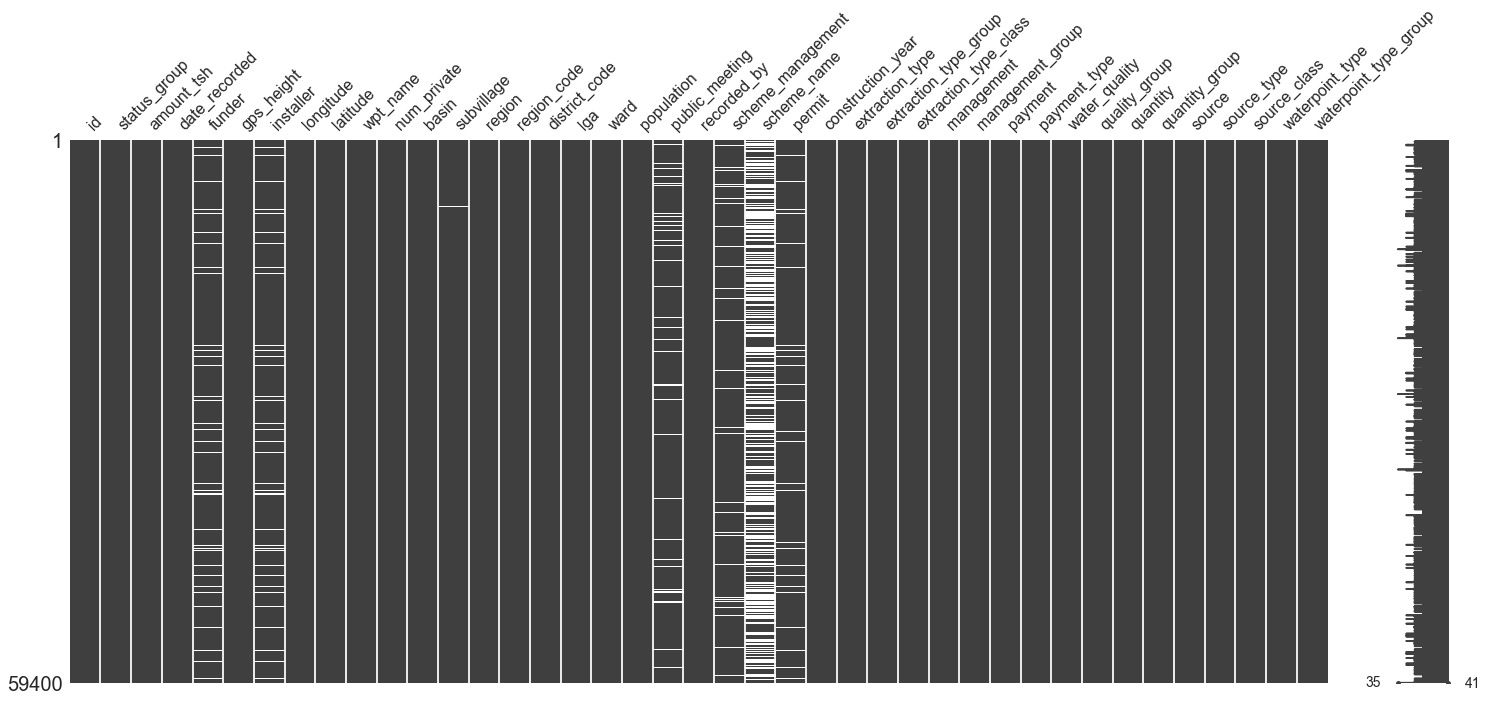

,#null,%null
id,0,0.00000000
status_group,0,0.00000000
amount_tsh,0,0.00000000
date_recorded,0,0.00000000
funder,3635,6.12000000
gps_height,0,0.00000000
installer,3655,6.15000000
longitude,0,0.00000000
latitude,0,0.00000000
wpt_name,0,0.00000000


In [10]:
#checking for null values
missingno.matrix(training_df)
plt.show()
null_check = pd.DataFrame({
    '#null':training_df.isna().sum(),
    '%null':round(training_df.isna().sum()/len(training_df)*100,2)
})
null_check

In [11]:
#Check for nulls that may be represented by zeros by showing unique values for
#each feature

for column in training_df:
    print(training_df[column].value_counts(dropna=False).head(30))
    print("Number of unique values: ")
    print(len(training_df[column].value_counts()))
    print()

69572    1
27851    1
6924     1
61097    1
48517    1
62700    1
48914    1
479      1
12824    1
21909    1
72568    1
10811    1
54353    1
16402    1
22305    1
54963    1
13966    1
40441    1
44155    1
1966     1
41217    1
21800    1
8962     1
20362    1
20788    1
64084    1
70884    1
47429    1
23781    1
61731    1
Name: id, dtype: int64
Number of unique values: 
59400

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64
Number of unique values: 
3

0.00000000        41639
500.00000000       3102
50.00000000        2472
1000.00000000      1488
20.00000000        1463
200.00000000       1220
100.00000000        816
10.00000000         806
30.00000000         743
2000.00000000       704
250.00000000        569
300.00000000        557
5000.00000000       450
5.00000000          376
25.00000000         356
3000.00000000       334
1200.00000000       267
1500.00000000       197
6.00000000          1

In [12]:
#Checking for unique details in the dataset
training_df.nunique()

id                       59400
status_group                 3
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_qu

***Removing of unnecessary columns
* id,date_recorded,recorded_by,wpt_name I determined to be irrelevant to the model
* amount_tsh is ~70% zeros,num_private is is ~99% zeros  
* payment_type I determined to be equivalent to payment and therefore redundant
* quantity_group I determined to be nearly equivalent to quantity and therefore redundant
* waterpoint_type_group I determined to be nearly eqivalent to waterpoint_type and therefore redundant
* scheme_name is ~50% nulls
* subvillage This feature has an unrealistic number of values to OneHotEncode and can be captured by other geographic features
* funder,installer,ward has too many values to model 

In [13]:
training_df2 = training_df.drop(columns  = ['id','amount_tsh',  'num_private', 'date_recorded', 
          'quantity_group', 'recorded_by','payment_type', 
          'waterpoint_type_group', 'scheme_name', 'subvillage', 'wpt_name',
            'funder', 'installer', 'ward'], axis = 1)

#Display remaining columns
training_df2.columns

Index(['status_group', 'gps_height', 'longitude', 'latitude', 'basin',
       'region', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type'],
      dtype='object')

In [14]:

training_df2.head()

,status_group,gps_height,longitude,latitude,basin,region,region_code,district_code,lga,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
0,functional,1390,34.93809275,-9.85632177,Lake Nyasa,Iringa,11,5,Ludewa,109,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe
1,functional,1399,34.69876610,-2.14746569,Lake Victoria,Mara,20,2,Serengeti,280,NaN,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe
2,functional,686,37.46066446,-3.82132853,Pangani,Manyara,21,4,Simanjiro,250,True,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple
3,non functional,263,38.48616088,-11.15529772,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,58,True,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple
4,functional,0,31.13084671,-1.82535885,Lake Victoria,Kagera,18,1,Karagwe,0,True,NaN,True,0,gravity,gravity,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe


We have columns that have nulls represented by zeros

Tanzania does not include null island (0 degrees, 0 degrees), but there are occurances of these coordinates in the data. As a result, the rows containing these points were dropped, as they represent only 3\% of the data and the model is only predicting well functionality inside of Tanzania.

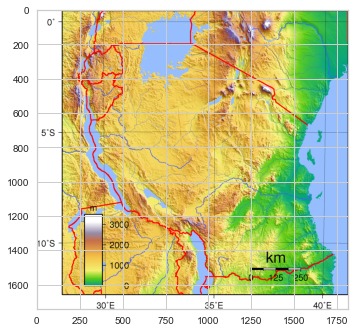

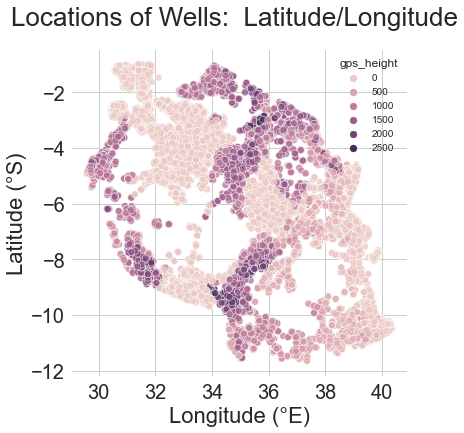

In [15]:
#Drop bad longitude/latitude rows
training_df2 = training_df2[training_df2['longitude'] != 0]

#Import image of Tanzania
image = mpimg.imread("Tanzania_Topography.png")
plt.imshow(image)
plt.show()

#Display updated coordinates to check for any other anomalies
fig, ax = plt.subplots(figsize=(6,6))
training_df3 = training_df[training_df['latitude'] != 0]
training_df4 = training_df3[training_df3['longitude'] != 0]
sns.scatterplot(x = training_df4['longitude'], y = training_df4['latitude'], hue = training_df4['gps_height'],
                marker='o', alpha=0.75)
sns.despine(left=True,bottom=True)
plt.suptitle('Locations of Wells:  Latitude/Longitude', fontsize=26)
plt.xlabel('Longitude (°E)', fontsize=22)
plt.ylabel('Latitude (°S)', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [16]:
# Replace zeros for median for gps_height and population

columns = ['gps_height', 'population']

for column in columns:
    training_df2[column].replace(0, training_df2[column].median() , inplace=True)
    training_df2[column].replace(0, training_df2[column].median() , inplace=True)
    
display(training_df2['gps_height'].value_counts())
training_df2['gps_height'].value_counts()

 426     18648
-15         60
-16         55
-13         55
 1290       52
         ...  
 2378        1
-54          1
 2057        1
 2332        1
 2366        1
Name: gps_height, Length: 2427, dtype: int64

 426     18648
-15         60
-16         55
-13         55
 1290       52
         ...  
 2378        1
-54          1
 2057        1
 2332        1
 2366        1
Name: gps_height, Length: 2427, dtype: int64

In [17]:
display(training_df2['population'].value_counts())
training_df2['population'].value_counts()

35      19814
1        7025
200      1940
150      1892
250      1681
        ...  
646         1
1942        1
672         1
2630        1
788         1
Name: population, Length: 1048, dtype: int64

35      19814
1        7025
200      1940
150      1892
250      1681
        ...  
646         1
1942        1
672         1
2630        1
788         1
Name: population, Length: 1048, dtype: int64

In [18]:
#Checking dtypes
training_df2.dtypes

status_group              object
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
population                 int64
public_meeting            object
scheme_management         object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

In [19]:
# Replace zeros with median for construction_year

training_df2['construction_year'].replace(0, training_df2['construction_year'].median(),
                                     inplace=True)

Convert permit and public_meeting to an integer

In [20]:
# Fill nulls with False for permit and public_meeting
training_df2['permit'] = training_df2['permit'].fillna(value = False)
training_df2['public_meeting'] = training_df2['public_meeting'].fillna(value = False)

In [21]:
training_df2['permit'] = training_df2['permit'].astype('int')
training_df2['public_meeting'] = training_df2['public_meeting'].astype('int')

training_df2.dtypes

status_group              object
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

In [22]:
#Converting region_code and district_code to categorical features
training_df2['region_code'] = training_df2['region_code'].astype('str')
training_df2['district_code'] = training_df2['district_code'].astype('str')
training_df2['region_code'] = training_df2['region_code'].astype('str')
training_df2['district_code'] = training_df2['district_code'].astype('str')
display(training_df2.dtypes)
training_df2.dtypes

status_group              object
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code               object
district_code             object
lga                       object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

status_group              object
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code               object
district_code             object
lga                       object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

# Exploring the Data

<AxesSubplot:xlabel='status_group', ylabel='count'>

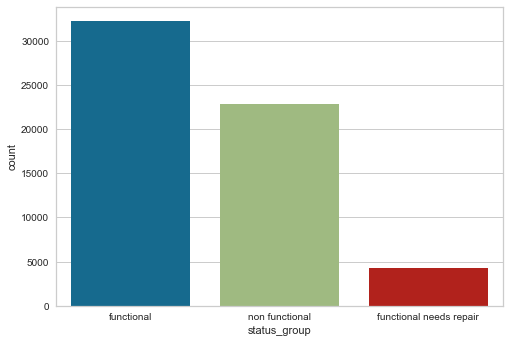

In [23]:
#Checking the  class imbalance

sns.countplot(x='status_group', data=training_df)

functional but needs repairs have less pumps while functional has more pumps than the rest, non functional pumps also have a
higher number hence needs to be addressed

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

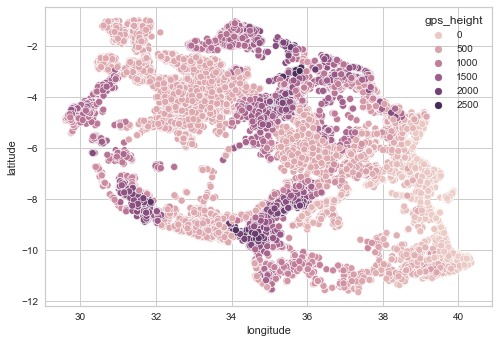

In [24]:
#checking distribution of pumps across Tanzania
sns.scatterplot(x=training_df2['longitude'], y=training_df2['latitude'],
            hue=training_df2['gps_height'])

# Training test split

In [25]:
# Conduct train test split to create training and testing data groups for
# future modeling

y = training_df2['status_group'].copy()
X = training_df2.drop(columns=['status_group']).copy()

X_train, X_test, y_train,y_test  = train_test_split(X,y,test_size=.3,
                                                    random_state=4,
                                                    stratify=y)
y_train.value_counts(normalize=True)

functional                0.54506214
non functional            0.38666865
functional needs repair   0.06826921
Name: status_group, dtype: float64

In [26]:
#Create list of numerical and categorical columns for use in upcoming pipeline

numerical_cols = list(X_train.select_dtypes(['float64', 'int64','int32']).columns)
categorical_cols = list(X_train.select_dtypes('object').columns)
numerical_cols,categorical_cols

(['gps_height',
  'longitude',
  'latitude',
  'population',
  'public_meeting',
  'permit',
  'construction_year'],
 ['basin',
  'region',
  'region_code',
  'district_code',
  'lga',
  'scheme_management',
  'extraction_type',
  'extraction_type_group',
  'extraction_type_class',
  'management',
  'management_group',
  'payment',
  'water_quality',
  'quality_group',
  'quantity',
  'source',
  'source_type',
  'source_class',
  'waterpoint_type'])

In [27]:
#Create numerical transformer

numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median'))])

#Create categorical transformer

categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='MISSING')),
    ('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

In [28]:
#Create preprocessor pipeline by combining pipelines into one

preprocessor=ColumnTransformer(transformers=[
    ('num',numerical_transformer,numerical_cols),
    ('cat',categorical_transformer,categorical_cols)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['gps_height', 'longitude', 'latitude',
                                  'population', 'public_meeting', 'permit',
                                  'construction_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['basin', 'region', 'region_code',
                                  'district_code', 'lga', 'scheme_management',
                                  'extraction_type', 'extraction_type_group',
                                  'extraction_type_class', 'management',
                                  'management_group', 'payment',
                                  'water_quality', 'quality_group', 'quantity',
                                  'source', 'source_type', 'source_class',
                                  'waterpoint_type'])])

In [29]:
# Fit preprocessing pipeline on training data 
# and pull out the feature names and X_cols

preprocessor.fit(X_train)

# Use the encoder's .get_feature_names
categorical_features = list(preprocessor.named_transformers_['cat']
                            .named_steps['encoder']\
                            .get_feature_names(categorical_cols))
X_cols = numerical_cols+categorical_features

# Transform X_train, X_test and remake dataframes
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index, columns=X_cols)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          index=X_test.index, columns=X_cols)

# Tranform X_train and X_test and make into dataFrames
X_train_df.head()

,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,region_code_1,region_code_10,region_code_11,region_code_12,region_code_13,region_code_14,region_code_15,region_code_16,region_code_17,region_code_18,region_code_19,region_code_2,region_code_20,region_code_21,region_code_24,region_code_3,region_code_4,region_code_40,region_code_5,region_code_6,region_code_60,region_code_7,region_code_8,...,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
27763,426.00000000,35.84192539,-6.11900732,35.00000000,1.00000000,0.00000000,1988.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
35894,915.00000000,35.93388954,-10.61029333,300.00000000,1.00000000,1.00000000,1991.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.

# Modeling

In [30]:
def model_evaluation(model, X_test_df, y_test, X_train_df, y_train, 
                     cmap='BuGn_r', normalize='true', 
                     classes=['functional', 'non functional',
                                   'functional needs repair'], figsize=(14,7),
                     n=30):
    """Function evaluates any sci-kit learn classification model with a class-
    ification report, confusion matrix, ROCAUC curves, and training and test
    scores. Additionally displays feature importances of model.
    
    Arguments-
    
    model: any scikit learn classification model
    X_test_df: X test data
    y_test: Y test data
    X_train_df: X training data
    y_train: Y training data
    cmap: color map for confusion matrix, defaults to Blues
    normalize: normalize argument for plot_confusion_matrix, 
               defaults to 'true'
    classes: list of classes to display for ROCAUC graph
    figsize: figure size defaults to 14,7
    n: number of features to display for feature importance figure

    """
    y_pred_test = model.predict(X_test_df)
    print(metrics.classification_report(y_test, y_pred_test))
    
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_df,y_test, normalize='true', 
                                  ax=ax[0], cmap='BuGn_r')
    
    visualizer = ROCAUC(model, classes=classes, ax=ax[1])
    visualizer.fit(X_train_df, y_train)
    visualizer.score(X_test_df, y_test)
    visualizer.show()
    
    plt.tight_layout()
    
    print(f"Training Score = {model.score(X_train_df,y_train):.2f}")
    print(f"Test Score = {model.score(X_test_df,y_test):.2f}")
    
    try: 
        feature_importance_df = pd.Series(model.feature_importances_,
                              index=X_train_df.columns)
        feature_importance_df.sort_values(ascending=True).tail(n).plot(
            kind='barh',figsize=figsize,title='Feature Importances',
            ylabel='Feature')
    except:
        pass
    
    return fig,ax

# Baseline Model (Dummy Classifier)

                         precision    recall  f1-score   support

             functional       0.55      0.55      0.55      9417
functional needs repair       0.08      0.08      0.08      1179
         non functional       0.39      0.39      0.39      6681

               accuracy                           0.46     17277
              macro avg       0.34      0.34      0.34     17277
           weighted avg       0.46      0.46      0.46     17277



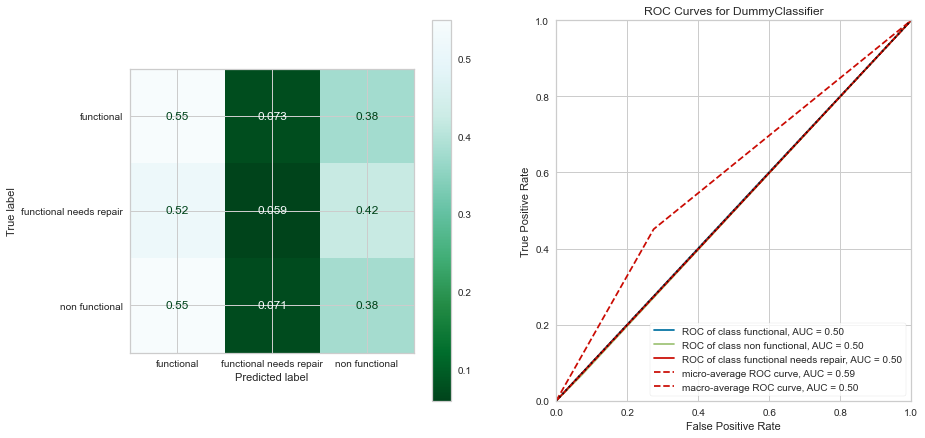

Training Score = 0.45
Test Score = 0.45


<Figure size 576x396 with 0 Axes>

In [31]:
#Create dummy classifier and evaluate

dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train_df,y_train)
model_evaluation(dummy_clf, X_test_df, y_test, X_train_df, y_train);



With an accuracy of 0.46 and f1 scores ranging from 0.08 to 0.55, the dummy classifier does no better than if one were to just guess the functional status group of the pump.

The confusion matrix above shows the discrepancy between the dummy classifier's predicted status group label for a given pump vs the true status group label. The dummy classifier does no better than guessing at random.

The ROCAUC figure above shows an AOC figure of 0.50, deeming the dummy classifier less useful.

The mean accuracy scores (0.45 for the training data and 0.45 for the test data) above show that while the dummy classifier is not over fit, it has a very poor mean accuracy.


# Decision Tree Classifier 1

We are starting with Decision trees to see how it performs compared to our baseline.

                         precision    recall  f1-score   support

             functional       0.67      0.95      0.79     21972
functional needs repair       0.65      0.02      0.03      2752
         non functional       0.85      0.51      0.64     15587

               accuracy                           0.72     40311
              macro avg       0.73      0.49      0.49     40311
           weighted avg       0.74      0.72      0.68     40311



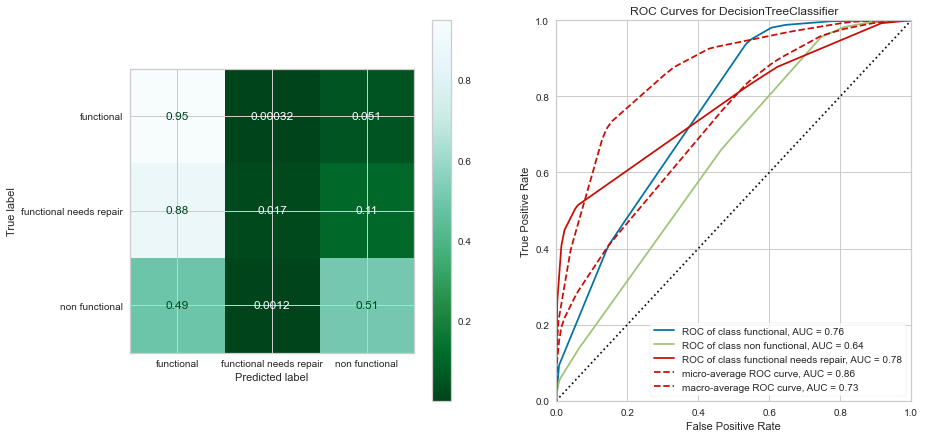

Training Score = 0.71
Test Score = 0.72


(<Figure size 1008x504 with 3 Axes>,
 array([<AxesSubplot:xlabel='Predicted label', ylabel='True label'>,
        <AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>],
       dtype=object))

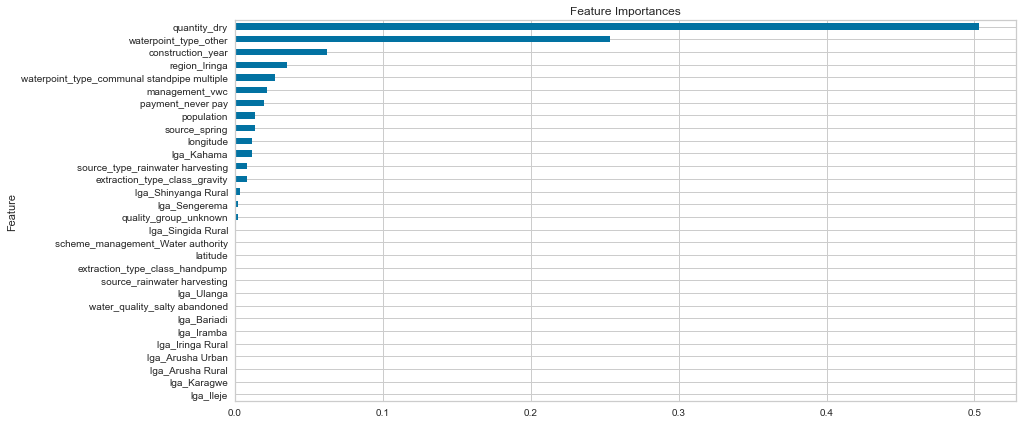

In [32]:
decision_tree = DecisionTreeClassifier(max_depth = 5, random_state = 4)
decision_tree.fit(X_train_df, y_train)

model_evaluation(decision_tree, X_train_df, y_train, X_test_df, y_test)

this model has performed much better compared to the baseline model with a mean accuracy of 0.72 and F1 scores ranging between
0.03 to 0.79.However the functional and needs repair has very low scores with high variances hence not a suitable model for the 
analysis.
The feature importance figure shows how important each respective feature is to the model in predicting the status group for a given pump. waterpoint type,region, quantity, and construction year were  the most important.


# Decision tree classifier 1 : Hyperparameter Tuning

Analysing which parameters might be best suit for this model

In [33]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_df, y_train)

DecisionTreeClassifier()

In [34]:
param_dict = {
    "criterion":['gini', 'entropy'],
    "max_depth":[1, 10, 25, 50],
    "min_samples_split":range(1, 10),
    "min_samples_leaf":range(1, 10)
}

#tw = GridSearchCV(estimator=decision_tree,
                 #param_grid=param_dict,
                 #cv=5,
                 #verbose=1,
                 #n_jobs=-1)
#tw.fit(X_train_df, y_train)

In [35]:
tw = GridSearchCV(estimator=decision_tree,
                 param_grid=param_dict,
                 cv=5,
                 verbose=1,
                 n_jobs=-1)
tw.fit(X_train_df, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 25, 50],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [36]:
print(tw.best_params_)
print(tw.best_estimator_)
print(tw.best_score_)

{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 8, 'min_samples_split': 7}
DecisionTreeClassifier(criterion='entropy', max_depth=25, min_samples_leaf=8,
                       min_samples_split=7)
0.7638610578262789




Here we found that the best parameters for our Decision Tree model are
criterion = 'entropy', max_depth = 25, min_samples_leaf = 8

it took 30minutes to load,Kept getting different min_samples_split value without results changing so it seems criterion, max_depth, & and min_samples_leaf give us a consistent enough result that min_samples_split does not need to be manipulated by us.


# Decision tree classifier 2

                         precision    recall  f1-score   support

             functional       1.00      1.00      1.00     21972
functional needs repair       1.00      1.00      1.00      2752
         non functional       1.00      1.00      1.00     15587

               accuracy                           1.00     40311
              macro avg       1.00      1.00      1.00     40311
           weighted avg       1.00      1.00      1.00     40311



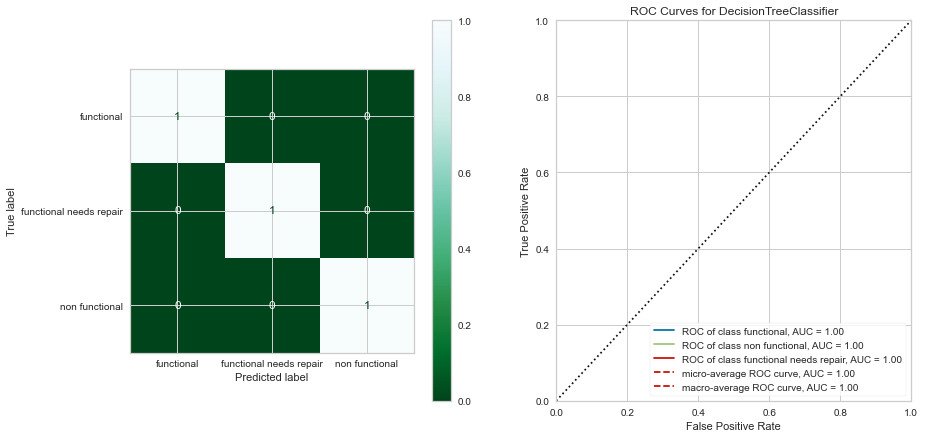

Training Score = 0.75
Test Score = 1.00


(<Figure size 1008x504 with 3 Axes>,
 array([<AxesSubplot:xlabel='Predicted label', ylabel='True label'>,
        <AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>],
       dtype=object))

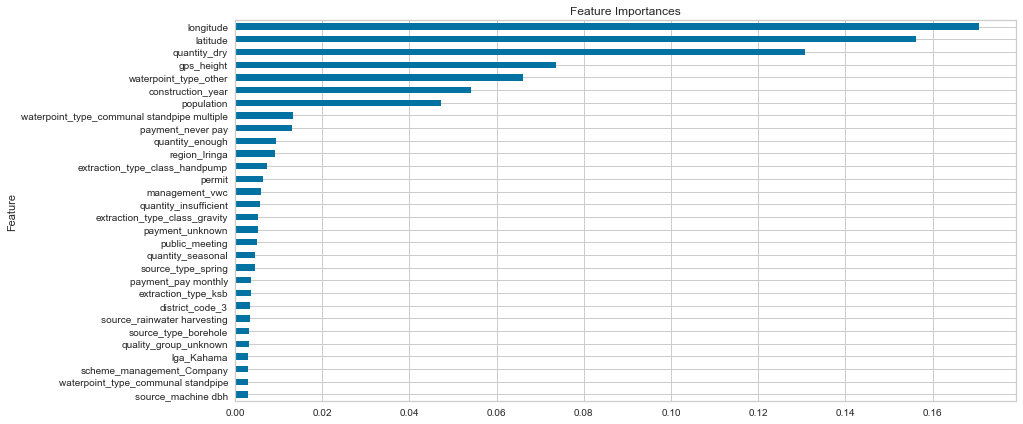

In [37]:
#second model utilizing those parameters.
decision_tree_better = DecisionTreeClassifier(random_state = 4, criterion = 'entropy', 
                                              max_depth = 25, min_samples_leaf = 8)
decision_tree_better.fit(X_train_df, y_train)

model_evaluation(decision_tree, X_train_df, y_train, X_test_df, y_test)

the first model looks better than the second model, the second model has overfitting problems with an accuracy score of 1.Lets look at a different model may be it will work much better.

The feature importance figure shows how important each respective feature is to the model in predicting the status group for a given pump. Longitude, latitude, gps height, population,waterpoint type, quantity, and construction year were  the most important.


# Randomforest classifier

                         precision    recall  f1-score   support

             functional       0.80      0.88      0.84      9417
functional needs repair       0.48      0.31      0.38      1179
         non functional       0.83      0.78      0.80      6681

               accuracy                           0.80     17277
              macro avg       0.71      0.65      0.67     17277
           weighted avg       0.79      0.80      0.79     17277



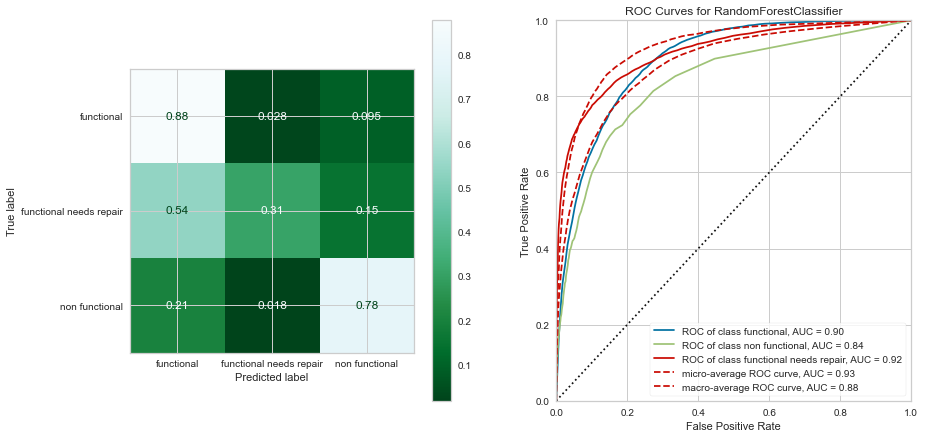

Training Score = 1.00
Test Score = 0.80


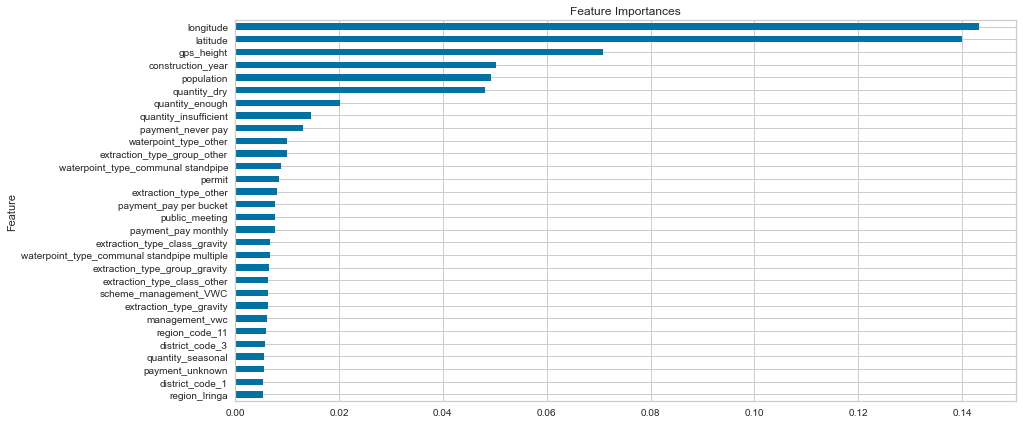

In [38]:
#Create randomforest model and evaluate

rf_1 = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                              random_state=4)
rf_1.fit(X_train_df, y_train)
model_evaluation(rf_1, X_test_df, y_test, X_train_df, y_train);



With an accuracy of 0.80 and f1 scores of 0.38, 0.80, and 0.84, the model is much better than the decision tree model

The confusion matrix above shows the discrepancy between the Random Forest's predicted status group label for a given pump vs the true status group label. The model does an excellent job predicting the functional and non functional statuses correctly. However, it struggles to accurately predict the functional needs repair status (precision of 0.48 and recall of 0.31).

The ROCAUC figure above shows an AOC figure of 0.90 for functional, 0.84 for non functional, and 0.92 for functional needs repair, deeming the initial Random Forest model quite impressive.

The mean accuracy scores (1 for the training data and 0.79 for the test data) above show that the Random Forest is overfit. However, it does have an impressive mean accuracy score for the test data.

The feature importance figure shows how important each respective feature is to the model in predicting the status group for a given pump. Longitude, latitude, gps height, population, quantity, and construction year were  the most important.


# RandomForestClassifier 1: Hyperparameter Tuning

With an intention of optimizing the scores for functional but need repairs

In [39]:
X_train_df.shape

(40311, 328)

In [40]:
#Create parameters grid for use in the GridSearch

param_grid = {'criterion':['gini','entropy'],
              'min_samples_split':[1,2,4],
             'n_estimators':[1000,1250,1500],
             'max_depth':[10,15,20]}

#Create GridSearchCV instance, prioritizing recall
#and cross validating 3 times

grid_rf_1 = GridSearchCV(rf_1, param_grid=param_grid, scoring='recall_macro',
                         cv=3, n_jobs=-1, verbose=True)

grid_rf_1.fit(X_train_df, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=4),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'min_samples_split': [1, 2, 4],
                         'n_estimators': [1000, 1250, 1500]},
             scoring='recall_macro', verbose=True)

In [41]:
#Display best score and best parameters from the GridSearch
print('Best Score: ')
print(grid_rf_1.best_score_)
print('Best Parameters: ')
print(grid_rf_1.best_params_)

Best Score: 
0.700700670313215
Best Parameters: 
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 1500}


# Random forest classifier 2

Create second iteration of the Random Forest using the parameters from the first GridSearch

                         precision    recall  f1-score   support

             functional       0.82      0.83      0.83      9417
functional needs repair       0.34      0.53      0.41      1179
         non functional       0.86      0.75      0.80      6681

               accuracy                           0.78     17277
              macro avg       0.67      0.70      0.68     17277
           weighted avg       0.80      0.78      0.79     17277



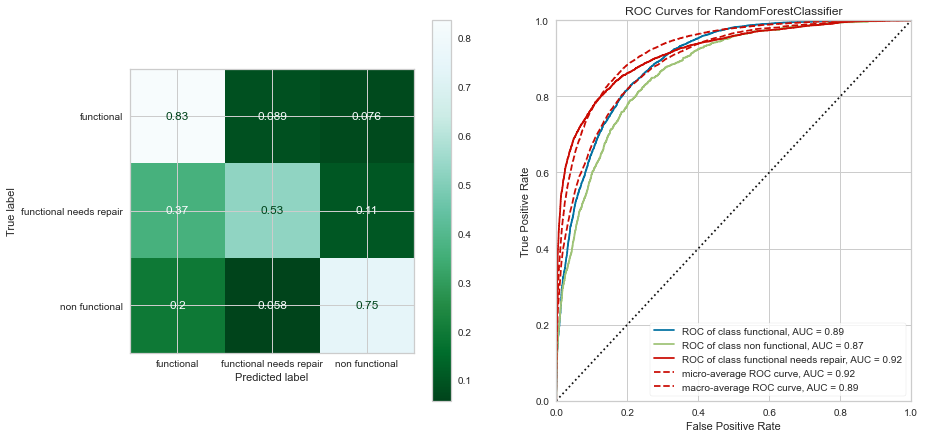

Training Score = 0.89
Test Score = 0.78


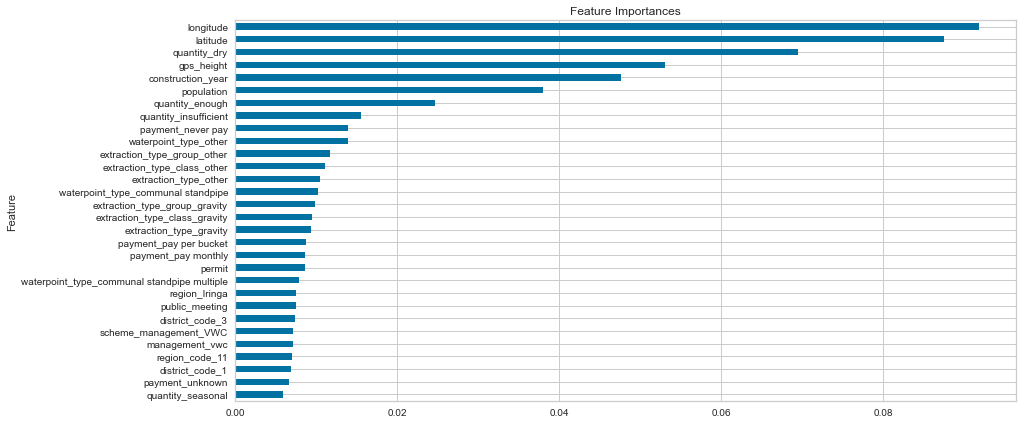

In [42]:
rf_2 = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                              random_state=4, **grid_rf_1.best_params_)
rf_2.fit(X_train_df, y_train)
model_evaluation(rf_2, X_test_df, y_test, X_train_df, y_train);



With an accuracy of 0.78 and f1 scores of 0.41, 0.80, and 0.83, the second iteration of the Random Forest has improved the overall accuracy of the model, functional needs repair recall, and reduced how overfit it is.

The confusion matrix above shows the discrepancy between the Random Forest's predicted status group label for a given pump vs the true status group label. The second iteration of the model does a better job predicting the
functional and non functional statuses correctly. It has also improved the recall for functional needs repair.

The ROCAUC figure above shows an AOC figure of 0.89 for functional, 0.87 for non functional, and 0.92 for functional needs repair, making this model more appropriate.

The mean accuracy scores (0.89 for the training data and 0.78 for the test data) above show that the Random Forest is still overfit. However, it has reduced the level of over fitting by improving the test mean accuracy.

The above bar graph shows how important each respective feature is to the model in predicting the status group for a given pump. Longitude, latitude, gps height, population, quantity, and construction year were deemed the most important again.


# KNearestNeighbors 1

I am creating this model to compare and see which model is will be better of the three

                         precision    recall  f1-score   support

             functional       0.69      0.81      0.74      9417
functional needs repair       0.36      0.16      0.22      1179
         non functional       0.67      0.57      0.62      6681

               accuracy                           0.67     17277
              macro avg       0.57      0.51      0.53     17277
           weighted avg       0.66      0.67      0.66     17277



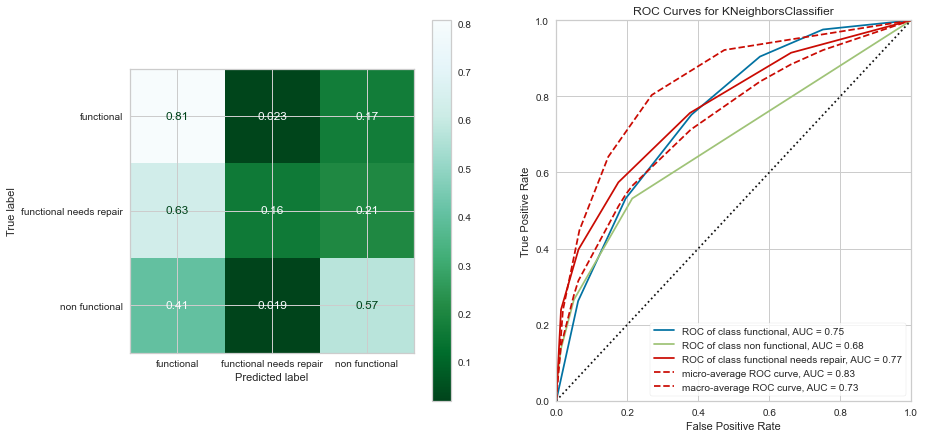

Training Score = 0.77
Test Score = 0.67


<Figure size 576x396 with 0 Axes>

In [72]:
knn_model_baseline = KNeighborsClassifier()
knn_model_baseline.fit(X_train_df, y_train)
model_evaluation(knn_model_baseline, X_test_df, y_test, X_train_df, y_train);

The ROC values are 0.75 for functional,0.68 for non functional and 0.77 for functional needs repair are lower compared to our 
previous model. The accuracy score is also 0.67 which is lower hence this will not be an appropriate model for the analysis

# KNearestNeighbors 1: Hyperparameter Tuning

Tuning the parameters to optimize the model

In [73]:
knn_grid = {
    'n_neighbors': [3, 5, 7],
    'metric' : ['minkowski', 'manhattan'],
    'weights': ['uniform', 'distance']
}

In [75]:
knn_gs = GridSearchCV(estimator=knn_model_baseline, param_grid=knn_grid,
                      cv=5, n_jobs=1)
knn_gs.fit(X_train_df, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [77]:
knn_gs.best_params_

{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

# KNearestNeighbors 2

                         precision    recall  f1-score   support

             functional       0.73      0.82      0.77      9417
functional needs repair       0.40      0.24      0.30      1179
         non functional       0.73      0.65      0.69      6681

               accuracy                           0.72     17277
              macro avg       0.62      0.57      0.59     17277
           weighted avg       0.71      0.72      0.71     17277



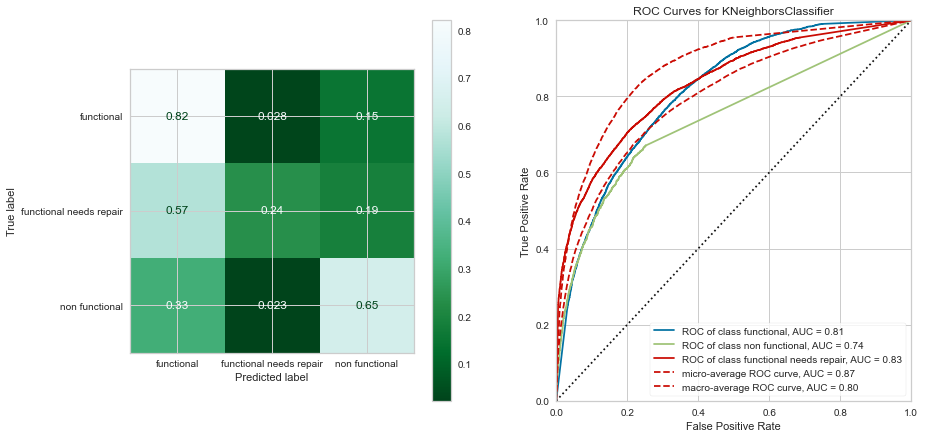

Training Score = 1.00
Test Score = 0.72


<Figure size 576x396 with 0 Axes>

In [78]:
knn_model1 = KNeighborsClassifier(metric='manhattan',
                                   n_neighbors=7,
                                   weights='distance')
knn_model1.fit(X_train_df, y_train)
model_evaluation(knn_model1, X_test_df, y_test, X_train_df, y_train);

This model has performed much better than the previous model as the accuracy score has increased but Random forest model 2 still remains to be the best model of all.

# Evaluation

After comparing the models, I believe the second iteration of the random forest models, rf_2, is the most promising regarding addressing the business problem. While it does struggle with being over fit and correctly identifying functional needs repair pumps, it is much less over fit than its first iteration, and has impressive recall scores for functional and non functional

As per the rf_2 the features of importance were;Longitude, latitude, gps height, population, quantity, and construction year.

# Water quantity vs the status of the pump

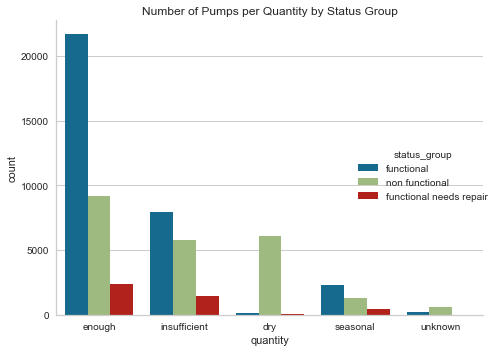

In [87]:
#Create visual interpreting quantity feature

sns.catplot(data=training_df, kind='count', x='quantity', hue='status_group')
plt.title('Number of Pumps per Quantity by Status Group')
plt.tight_layout()

The figure above shows how as water quantity decreases, pumps are more likely to be non functional

# Population vs the status of the pump

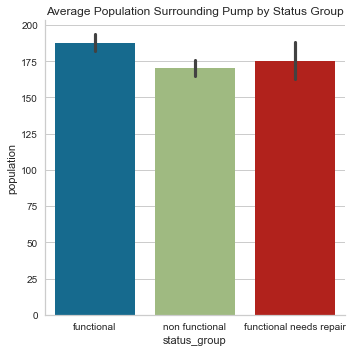

In [88]:
#Create visual to interpret population

sns.catplot(data=training_df, kind='bar', y='population', x='status_group')
plt.title('Average Population Surrounding Pump by Status Group')
plt.tight_layout()

The figure above shows how pumps in areas of lower population may be more likely to be needing repair or non functional

# Construction year vs the status of the pump

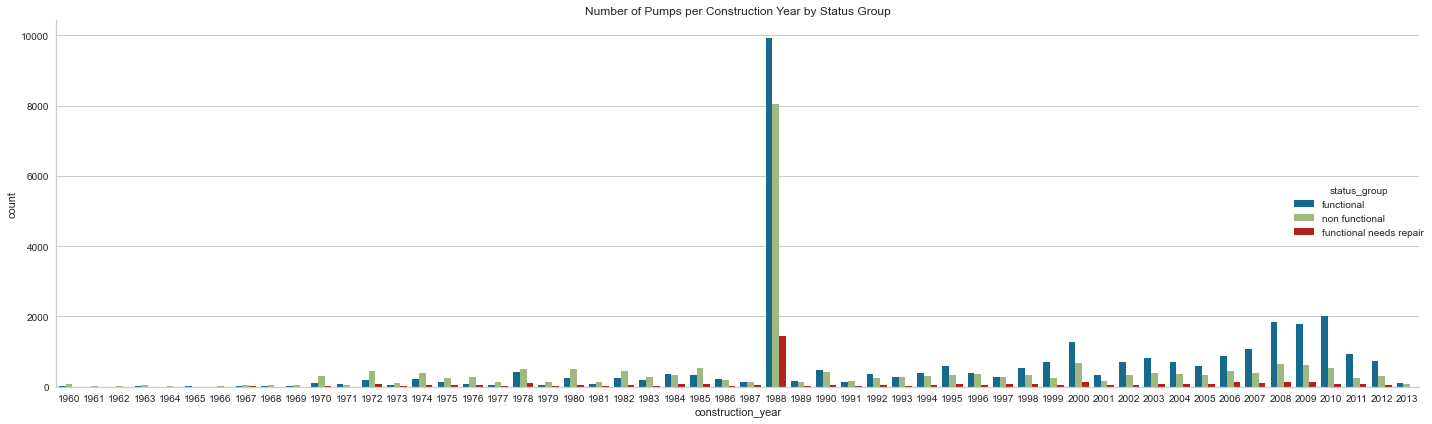

In [90]:
#Create visual to interpret construction year

sns.catplot(data=training_df2, kind='count', x='construction_year',
            hue='status_group', orient='h', aspect=3, height=6)
plt.title('Number of Pumps per Construction Year by Status Group')
plt.tight_layout()

The figure above shows how older pumps are more likely to be nonfunctional or needing repair

# Location vs the status of the pump

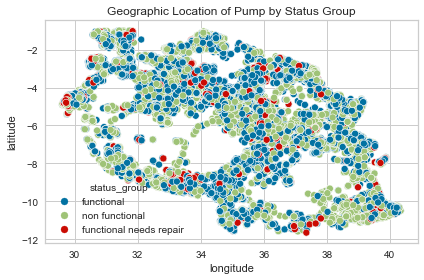

In [91]:
#Create visual to interpret location

sns.scatterplot(data=training_df2, x='longitude', y='latitude',
                hue='status_group')
plt.title('Geographic Location of Pump by Status Group')
plt.tight_layout()

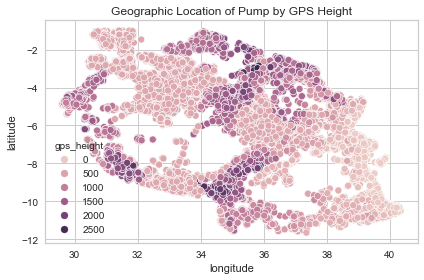

In [94]:
#Create visual to interpret location

sns.scatterplot(x=training_df2['longitude'],
                y=training_df2['latitude'],
                hue=training_df2['gps_height'])
plt.title('Geographic Location of Pump by GPS Height')
plt.tight_layout()

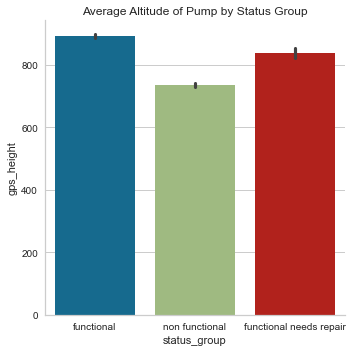

In [95]:
#Create visual to interpret location

sns.catplot(data=training_df2, kind='bar', y='gps_height', x='status_group')
plt.title('Average Altitude of Pump by Status Group')
plt.tight_layout()


The figures above show that pumps in lower altitude areas may be more likely to be non functional

# CONCLUSIONS & RECOMMENDATIONS



Based on this random forest classifier model two, I would provide four recommendations to the Tanzania Government as they look to improve pump status prediction and maintenance efficiency:

- Construction Year: Construction Year was one of the most important features in the random forest classifier. Analysis showed that older pumps may be more likely to be nonfunctional or needing repair. The government should focus resources on modernizing older pumps.

- Location: Longitude, latitude, and gps height were some of the most important features in the random forest classifier. Based on the analysis, pumps in lower altitude areas may be more likely to need repair or be non functional. The government should focus resources on lower altitude pumps.

- Quantity: Quantity was one of the most important features in the random forest classifier. Analysis showed that pumps with lower quantities of water were more likely to be non functional or needing repair. The government should focus resources on pumps with low quantities of water.

- Population: Population was one of the most important features in the random forest classifier. Analysis showed that pumps in lower population areas may be more likely to be non functional or needing repairs. The government should focus resources on low population areas, as they may not be receiving enough.



